### Load Module and Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [19]:
data = pd.read_excel('rcal.xlsx')
data

,Sample Number,Well,Sample ID,Top Interval (ft),Base Interval (ft),Permeability (mD),Porosity (%),Remarks
0,1,KG-1X,1,4461,4474,0.008,9.1,CS
1,2,KG-1X,3,8047,8069,0.008,6.9,CH
2,3,KG-2AX,3,4184,4243,0.008,8.0,CH
3,4,KG-2AX,3,4184,4243,0.008,6.9,CH
4,5,KG-2AX,3,4184,4243,0.009,10.0,CH
...,...,...,...,...,...,...,...,...
333,334,KG-3X,1,4038,4091,4211.000,29.4,DF
334,335,KG-2AX,3,4184,4243,4393.500,30.0,DF
335,336,KG-2AX,3,4184,4243,4575.300,25.4,DF
336,337,KG-3X,1,4038,4091,6262.200,30.0,DF


In [20]:
data['por'] = data['Porosity (%)']/100
data['perm'] = data['Permeability (mD)']

### Porosity - Permeability Crossplot

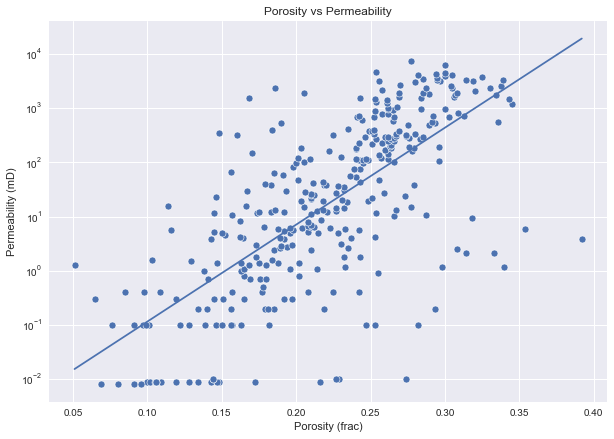

In [21]:
f, ax = plt.subplots(figsize=(10, 7))
coef = np.polyfit(data['por'],np.log(data['perm']),1)
sns.lineplot(x=data['por'],y=np.exp(coef[1] + coef[0]*data['por']), ax=ax, markers=True)
sns.scatterplot(x="por", y="perm",data=data, ax=ax)
ax.set(xscale="linear", yscale="log")
ax.set_xlabel('Porosity (frac)')
ax.set_ylabel('Permeability (mD)')
ax.set_title('Porosity vs Permeability')
plt.savefig('poro-perm-crossplot.png', dpi=200)

### RQI, FZI, dan DRT Calculations

In [22]:
data['RQI'] = 0.0314*np.sqrt(data['perm']/data['por'])
data['phi-z'] = data['por']/(1 - data['por'])
data['FZI'] = data['RQI']/data['phi-z']
data['DRT'] = round(2*np.log(data['FZI']) + 10.6)

### Rock Typing Based On HFU

In this part you may need to re-evaluate the DRT since there may be some DRT rocktype only have one or two data that may cause the regression poorly conditioned. As an example, i merge RT 2 with RT 3 since there are only one data in RT 2

In [23]:
data['DRT Rocktype'] = data['DRT'].transform(lambda x : "RT " + str(int(x)))
data['DRT Rocktype'] = data['DRT Rocktype'].replace("RT 2", "RT 3")

### Rock Typing results with HFU

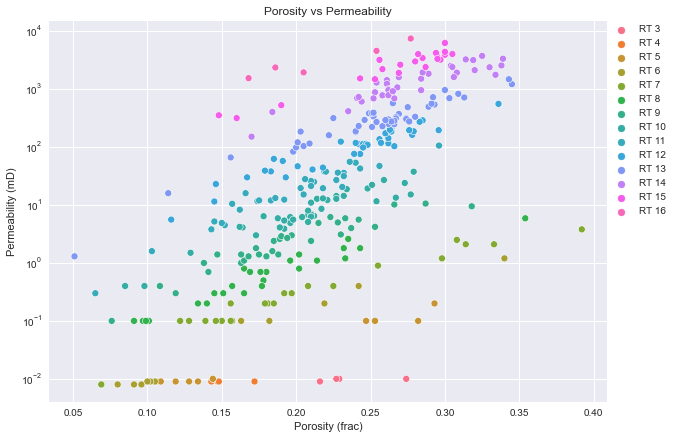

In [24]:
data = data.sort_values(by='DRT')
f, ax = plt.subplots(figsize=(10, 7))
ax.set(xscale="linear", yscale="log")
sns.scatterplot(x="por", y="perm", hue="DRT Rocktype", data=data, ax=ax)
ax.set_xlabel('Porosity (frac)')
ax.set_ylabel('Permeability (mD)')
ax.set_title('Porosity vs Permeability')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.savefig('hfu-results.png', dpi=200, bbox_inches='tight')

### Porosity-Permeability Regression on Each Rock Type

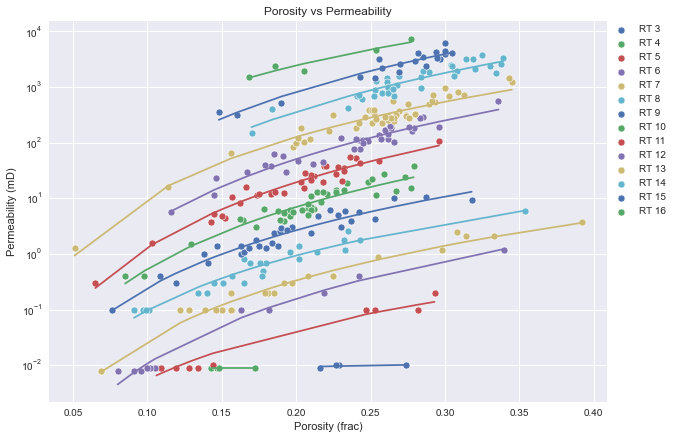

In [26]:
f, ax = plt.subplots(figsize=(10, 7))
labels = data['DRT Rocktype'].unique()
coeff_rocktype = []
for label in labels:
    sns.scatterplot(x=data[data['DRT Rocktype'] == label]['por'], 
                    y=data[data['DRT Rocktype'] == label]['perm'],
                    label=label,
                    ax=ax)
    coef = np.polyfit(np.log(data[data['DRT Rocktype'] == label]['por']),
                      np.log(data[data['DRT Rocktype'] == label]['perm']),
                      1)
    coeff_rocktype.append([label, coef])
    sns.lineplot(x=data[data['DRT Rocktype'] == label]['por'],y=(np.exp(coef[1])*((data[data['DRT Rocktype'] == label]['por'])**coef[0])), ax=ax, markers=True)
ax.set_xlabel('Porosity (frac)')
ax.set_ylabel('Permeability (mD)')
ax.set_title('Porosity vs Permeability')
ax.set(xscale="linear", yscale="log")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.savefig('hfu-regression.png', dpi=200, bbox_inches='tight')

### RQI - Phi-z Crossplot

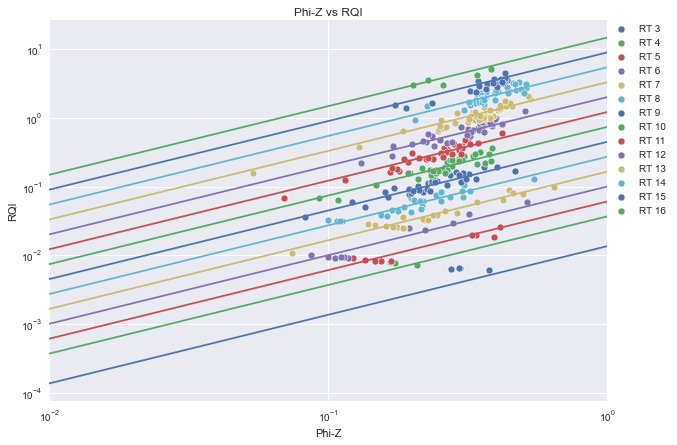

In [28]:
f, ax = plt.subplots(figsize=(10, 7))
labels = data['DRT Rocktype'].unique()
for label in labels:
    sns.scatterplot(x=data[data['DRT Rocktype'] == label]['phi-z'], 
                    y=data[data['DRT Rocktype'] == label]['RQI'],
                    label=label,
                    ax=ax)
    sns.lineplot(x=[0.01,1],
                 y=[0.01*np.exp(0.5*(data[data['DRT Rocktype'] == label]['DRT'].values[0] - 10.6)), 1*np.exp(0.5*(data[data['DRT Rocktype'] == label]['DRT'].values[0] - 10.6))])
ax.set_xlabel('Phi-Z')
ax.set_xlim(0.01,1)
ax.set_ylabel('RQI')
ax.set_title('Phi-Z vs RQI')
ax.set(xscale="log", yscale="log")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.savefig('rqi-phiz-crossplot.png', dpi=200, bbox_inches='tight')

### Porosity - Predicted Permeability Crossplot

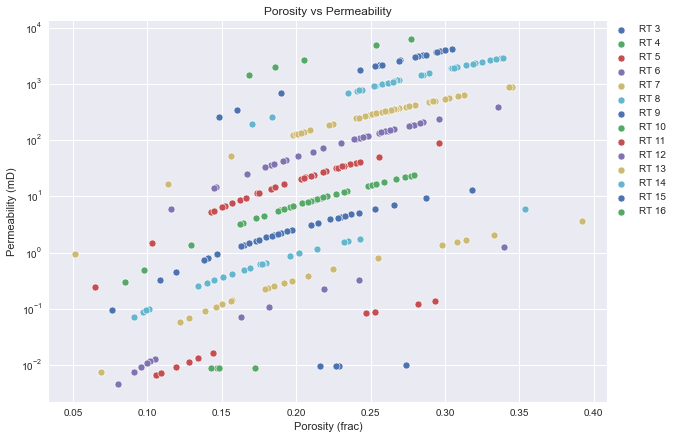

In [30]:
f, ax = plt.subplots(figsize=(10, 7))
ax.set(xscale="linear", yscale="log")
labels = data['DRT Rocktype'].unique()
for label in labels:
    coef = np.polyfit(np.log(data[data['DRT Rocktype'] == label]['por']),
                      np.log(data[data['DRT Rocktype'] == label]['perm']),
                      1)
    sns.scatterplot(x=data[data['DRT Rocktype'] == label]['por'],y=(np.exp(coef[1])*((data[data['DRT Rocktype'] == label]['por'])**coef[0])), ax=ax, markers=True, label=label)
ax.set_xlabel('Porosity (frac)')
ax.set_ylabel('Permeability (mD)')
ax.set_title('Porosity vs Permeability')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.savefig('poro-predperm.png', dpi=200, bbox_inches='tight')

### Predicted - True Permeability Crossplot

In [31]:
data.sort_values(by='DRT Rocktype')
pred_perm = []
labels = data['DRT Rocktype'].unique()
for label in labels:
    coef = np.polyfit(np.log(data[data['DRT Rocktype'] == label]['por']),
                      np.log(data[data['DRT Rocktype'] == label]['perm']),
                      1)
    predicted_perm = np.exp(coef[1])*((data[data['DRT Rocktype'] == label]['por'])**coef[0])
    pred_perm += predicted_perm.tolist()
data['Predicted Permeability (mD)'] = pred_perm

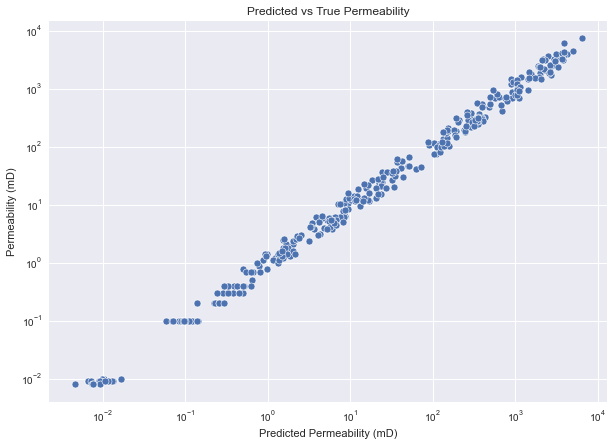

In [32]:
f, ax = plt.subplots(figsize=(10, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x="Predicted Permeability (mD)", y="Permeability (mD)",data=data, ax=ax)
ax.set_xlabel('Predicted Permeability (mD)')
ax.set_ylabel('Permeability (mD)')
ax.set_title('Predicted vs True Permeability')
plt.savefig('pred-true-crossplot.png', dpi=200)

### Summary of DRT Rock Type

In [51]:
summary_data = data.groupby('DRT Rocktype').mean()[['Permeability (mD)', 'Porosity (%)', 'DRT']].reset_index().sort_values(by='DRT').reset_index()[['DRT Rocktype', 'Permeability (mD)', 'Porosity (%)']]

In [52]:
b = []
a = []
for rt in coeff_rocktype:
    b.append(rt[1][0])
    a.append(np.exp(rt[1][1]))

In [53]:
summary_data['A'] = a
summary_data['B'] = b

In [54]:
summary_data

,DRT Rocktype,Permeability (mD),Porosity (%),A,B
0,RT 3,0.009750,23.650000,0.014604,2.801127e-01
1,RT 4,0.009000,15.250000,0.009000,-5.419625e-15
2,RT 5,0.044846,16.700000,5.461357,2.996471e+00
3,RT 6,0.186455,15.636364,81.070821,3.877844e+00
4,RT 7,0.640640,19.760000,101.014066,3.548502e+00
5,RT 8,0.944000,17.744000,181.262334,3.271493e+00
6,RT 9,3.168750,19.329375,675.568233,3.437870e+00
7,RT 10,10.265789,20.810263,2702.324299,3.701748e+00
8,RT 11,24.282857,19.706286,10175.820722,3.890436e+00
9,RT 12,122.279487,23.486667,29439.345615,3.952799e+00


The value of A and B are the coefficients for porosity permeability relation as follows.

${k} = A{\phi}^{B} $

Now you can input your equations for model permeability input for reservoir simulation